# Two-qubit gate learning with crosstalk
This notebook is designed to test noise learning through two-qubit clifford gates with crosstalk. I still have questions about how to do this while simultaneously twirling the noise. This example uses a pauli-channel noise model.

In [72]:
from qiskit.quantum_info import Operator, Pauli 
from qiskit.circuit.library import CXGate, CZGate, HGate, SGate
from qiskit import QuantumCircuit, Aer, execute
from qiskit.providers.aer.noise import depolarizing_error, NoiseModel

import numpy as np
from random import choices
from numpy.random import permutation
import matplotlib.pyplot as plt
from itertools import product
from scipy.optimize import curve_fit

## Pauli name tools

In [73]:
#iterate through all pauli strings and convert them to operators. indices are a convenient representation of ops
names = ["".join(str) for str in product(['I', 'X', 'Y','Z'], repeat=n)]
paulis = [Operator(Pauli(name)) for name in names]

#give this function a pauli matrix and it returns its name if it is on the list, e.g. "XIYZ"
def get_name(pauli_op):
    try:
        #iterate through gates and check if they are equivalent up to global phase
        return names[min([i for (i,gate) in enumerate(paulis) if pauli_op.equiv(gate)])]
    except:
        return -1

#simplifying conjugating a pauli by a clifford
def conjugate(pauli, cliffordop):
    return get_name(cliffordop.compose(Operator(Pauli(pauli).to_matrix())).compose(cliffordop))

## Basis change gates

In [92]:
#change from Z to the eigenvasis of desired pauli operator
def change_basis(pauli_str):
    qc = QuantumCircuit(len(pauli_str))
    for i,p in enumerate(pauli_str):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.h(i)
                qc.s(i)
            case _:
                qc.id(i)
    return qc.to_instruction()

def change_basis_back(pauli_str):
    qc = QuantumCircuit(len(pauli_str))
    for i,p in enumerate(pauli_str):
        match p:
            case 'X':
                qc.h(i)
            case 'Y':
                qc.sdg(i)
                qc.h(i)
            case _:
                qc.id(i)
    return qc.to_instruction()

## Generate fidelity pair list

In [175]:
def s_prod(a,b):
    return {True:0, False:1}[Pauli(a).commutes(Pauli(b))]

gate_to_benchmark = Operator(CXGate().to_matrix())
n=2
p1 = ["".join(s) for s in product("IXYZ", repeat = n)][1:]
p_group_permuted = [conjugate(p, gate_to_benchmark) for p in p1]

M1 = [[s_prod(a,b) for a in p1] for b in p1]
M2 = [[s_prod(a,b) for a in p_group_permuted] for b in p1]

M = np.add(M1, M2)

In [176]:
#just using products, this matrix is singular
try:
    np.linalg.inv(np.add(M1,M2))
except:
    print("Singular Matrix")

Singular Matrix


In [177]:
list(zip(p1, p_group_permuted))

[('IX', 'XX'),
 ('IY', 'XY'),
 ('IZ', 'IZ'),
 ('XI', 'XI'),
 ('XX', 'IX'),
 ('XY', 'IY'),
 ('XZ', 'XZ'),
 ('YI', 'YZ'),
 ('YX', 'ZY'),
 ('YY', 'ZX'),
 ('YZ', 'YI'),
 ('ZI', 'ZZ'),
 ('ZX', 'YY'),
 ('ZY', 'YX'),
 ('ZZ', 'ZI')]

In [189]:
p2 = p_group_permuted.copy()
paulis_to_fix = []
for i,(s1,s2) in enumerate(zip(p1, p_group_permuted)):
    if 'I' in s1:
        if 'I' not in s2:
            p2[i] = "II"
    else:
        p1[i] = s1 #the problem children

print(list(zip(p1, p2)))

[('IX', 'II'), ('IY', 'II'), ('IZ', 'IZ'), ('XI', 'XI'), ('XX', 'IX'), ('XY', 'IY'), ('XZ', 'XZ'), ('YI', 'II'), ('YX', 'ZY'), ('YY', 'ZX'), ('YZ', 'YI'), ('ZI', 'II'), ('ZX', 'YY'), ('ZY', 'YX'), ('ZZ', 'ZI')]


In [187]:
paulis_to_fix

['XX', 'XY', 'XZ', 'YX', 'YY', 'YZ', 'ZX', 'ZY', 'ZZ']

In [181]:
M1 = [[s_prod(a,b) for a in p1] for b in p1]
M2 = [[s_prod(a,b) for a in p2] for b in p2]

In [182]:
try:
    np.linalg.inv(np.add(M1,M2))
    print("Full rank!")
except:
    print("Singular matrix")

Full rank!


In [174]:
p = .01
onequbit_error = depolarizing_error(p, 1)
twoqubit_error = depolarizing_error(p, 2)
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(onequbit_error, ['id','x','y','z'])
noise_model.add_all_qubit_quantum_error(twoqubit_error, ['cx','cz'])
SHOTS = 1000

In [86]:
#get the expectation value of a pauli operator
def get_expectation(circuit, pauli_str):
    #switch basis and measure in Z basis
    circ = circuit.copy()
    circ.append(change_basis_back(pauli_str), range(len(pauli_str)))
    circ.measure_all()
    #create backend
    backend = Aer.get_backend('qasm_simulator')
    #extract counts from potentially noisy backend
    counts = execute(circ, backend, shots = SHOTS, noise_model = noise_model, basis_gates = noise_model.basis_gates, optimization_level=0).result().get_counts()
    #get expectation value
    total = 0
    pauli_str = pauli_str[::-1]
    for key in counts.keys():
        #compute overlap between key and P_z(i) to weight counts. If even, 1, if odd, -1
        total += (1-2*(np.sum([int(key_bit)*int({'I':'0'}.get(pauli_bit, '1')) for (key_bit,pauli_bit) in zip(key, pauli_str)])%2))*counts[key]
    return total/SHOTS

#measure the fidelity of a pauli operator after folding the noisy gate a certain number of times
def measure_circuit(pauli, folds):
    total = 0

    qc = QuantumCircuit(2)
    qc.append(change_basis(pauli),range(n))

    for i in range(folds):
        qc.append(gate_to_benchmark, range(n))
        qc.append(gate_to_benchmark, range(n))

    return qc 

In [96]:
pauli_group = ["".join(s) for s in product("IXYZ", repeat = 2)][1:]
lengths = [1,2,4,8,16,32]
pauli_fidelities = {p:[0]*len(lengths) for p in pauli_group}
for s in product("XYZ", repeat = 2):
    p = "".join(s)
    for i,l in enumerate(lengths):
        qc = measure_circuit(p, l)
        pauli_fidelities[p][i] += get_expectation(qc, p)
        pauli_fidelities[p[0]+"I"][i] += get_expectation(qc, p[0]+"I")/3
        pauli_fidelities["I"+p[1]][i] += get_expectation(qc,"I"+p[1])/3


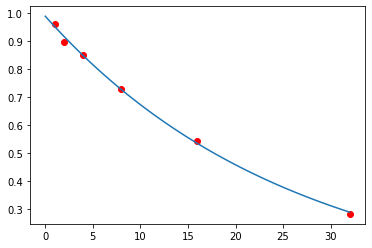

In [107]:
pauli = "IY"
plt.plot(lengths, pauli_fidelities[pauli], 'ro')
expfit = lambda x,a,b: np.exp(-b*x)*a
popt, pcov = curve_fit(expfit, lengths, pauli_fidelities[pauli])
xrange = np.linspace(0, np.max(lengths), 100)
plt.plot(xrange, [expfit(x, popt[0], popt[1]) for x in xrange])